In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os
os.chdir('/content/gdrive/MyDrive/')

Mounted at /content/gdrive


In [ ]:
%cd 'Hate_Speech/'

/content/gdrive/MyDrive/Hate_Speech


In [ ]:
# %cd ..

In [ ]:
!ls

'='		 data_utils.py			 model.py
 classifier.pt	 hate_speech_spanish_scl.ipynb	 __pycache__
 config.py	 loss_func.py			 README.md
 dataset	 main.py			 requirements.txt


In [ ]:
!pip install torch
!pip install numpy
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model import Transformer
from loss_func import CELoss, SupConLoss, DualLoss
from data_utils import load_data
from transformers import TFMT5Model, T5Tokenizer, logging, AutoTokenizer, AutoModel, AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import sys
import time
import random
from tqdm import tqdm
import logging
import argparse
from datetime import datetime
import numpy as np
import json
from functools import partial
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import warnings
# Settings the warnings to be ignored
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
class CELoss(nn.Module):

    def __init__(self):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        return self.xent_loss(outputs['predicts'], targets)

class ConLoss(nn.Module):

    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)
        # ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        return cl_loss

class SupConLoss(nn.Module):

    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)
        ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        return ce_loss + cl_loss

class AdversarialConLoss(nn.Module):
    def __init__(self, alpha, temp):
        super().__init__()
        self.xent_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.temp = temp

    def nt_xent_loss(self, anchor, target, labels):
        with torch.no_grad():
            labels = labels.unsqueeze(-1)
            mask = torch.eq(labels, labels.transpose(0, 1))
            # delete diag elem
            mask = mask ^ torch.diag_embed(torch.diag(mask))
        # compute logits
        anchor_dot_target = torch.einsum('bd,cd->bc', anchor, target) / self.temp
        # delete diag elem
        anchor_dot_target = anchor_dot_target - torch.diag_embed(torch.diag(anchor_dot_target))
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_target, dim=1, keepdim=True)
        logits = anchor_dot_target - logits_max.detach()
        # compute log prob
        exp_logits = torch.exp(logits)
        # mask out positives
        logits = logits * mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        # in case that mask.sum(1) is zero
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum == 0, torch.ones_like(mask_sum), mask_sum)
        # compute log-likelihood
        pos_logits = (mask * log_prob).sum(dim=1) / mask_sum.detach()
        loss = -1 * pos_logits.mean()
        return loss

    def forward(self, outputs, targets):

        ce_loss = self.xent_loss(outputs['predicts'], targets)
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)

        unnormalized_noise = normed_cls_feats.clone()
        norm = unnormalized_noise.norm(p=2, dim=-1)
        normalized_noise = unnormalized_noise / (norm.unsqueeze(dim=-1) + 1e-10)  # add 1e-10 to avoid Nan

        noise_norm = 1.5 # or 0.00005
        alp = 0.5

        target_noise = noise_norm * normalized_noise
        noise_x_ = normed_cls_feats + target_noise
        noise_CEloss = self.xent_loss(noise_x_, targets)
        noise_scloss =self.nt_xent_loss(normed_cls_feats, noise_x_, targets)
        # noise_CEloss = F.nll_loss(F.log_softmax(self.fc(noise_x_), dim=1), data.y)

        #noise_loss = (1 - self.alpha) * noise_CEloss + self.alpha * noise_scloss

        scl_loss = self.alpha * self.nt_xent_loss(normed_cls_feats, normed_cls_feats, targets)
        total_loss = (1 - self.alpha) *(ce_loss + noise_CEloss)/2 + noise_scloss * self.alpha

        return  total_loss


class DualLoss(SupConLoss):

    def __init__(self, alpha, temp):
        super().__init__(alpha, temp)

    def forward(self, outputs, targets):
        normed_cls_feats = F.normalize(outputs['cls_feats'], dim=-1)

        normed_label_feats = F.normalize(outputs['label_feats'], dim=-1)
        normed_pos_label_feats = torch.gather(normed_label_feats, dim=1, index=targets.reshape(-1, 1, 1).expand(-1, 1, normed_label_feats.size(-1))).squeeze(1)
        ce_loss = (1 - self.alpha) * self.xent_loss(outputs['predicts'], targets)
        cl_loss_1 = 0.5 * self.alpha * self.nt_xent_loss(normed_pos_label_feats, normed_cls_feats, targets)
        cl_loss_2 = 0.5 * self.alpha * self.nt_xent_loss(normed_cls_feats, normed_pos_label_feats, targets)
        return ce_loss + cl_loss_1 + cl_loss_2

In [ ]:
class Instructor:

    def __init__(self, args, logger):
        self.args = args
        self.logger = logger
        self.logger.info('> creating model {}'.format(args.model_name))
        if args.model_name == 'xlm-roberta':
            # self.tokenizer = AutoTokenizer.from_pretrained('berta-base-multilingual-cased')
            self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            # self.tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

            # tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            # model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

            # base_model = AutoModel.from_pretrained('bert-base-multilingual-cased')
            base_model = AutoModel.from_pretrained("xlm-roberta-base")

            # base_model = TFMT5Model.from_pretrained('google/mt5-small')
            # self.tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

            # model = TFMT5Model.from_pretrained("google/mt5-small")
            # tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
        elif args.model_name == 'roberta':
            self.tokenizer = AutoTokenizer.from_pretrained('roberta-base-multilingual-cased', add_prefix_space=True)
            base_model = AutoModel.from_pretrained('roberta-base--multilingual-cased')
        elif args.model_name == 'mbert':
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', add_prefix_space=True)
            base_model = AutoModel.from_pretrained('bert-base-multilingual-cased')
        else:
            raise ValueError('unknown model')
        self.model = Transformer(base_model, args.num_classes, args.method)
        self.model.to(args.device)
        if args.device.type == 'cuda':
            self.logger.info('> cuda memory allocated: {}'.format(torch.cuda.memory_allocated(args.device.index)))
        self._print_args()

    def _print_args(self):
        self.logger.info('> training arguments:')
        for arg in vars(self.args):
            self.logger.info(f">>> {arg}: {getattr(self.args, arg)}")

    def _train(self, dataloader, criterion, optimizer):
        train_loss, n_correct, n_train = 0, 0, 0
        self.model.train()
        predictions, true_vals = [], []
        for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii=' >='):
            inputs = {k: v.to(self.args.device) for k, v in inputs.items()}
            targets = targets.to(self.args.device)
            outputs = self.model(**inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * targets.size(0)
            n_correct += (torch.argmax(outputs['predicts'], -1) == targets).sum().item()
            n_train += targets.size(0)

            predictions.append(outputs)
            true_vals.append(targets)

        return train_loss/n_train, n_correct/n_train, true_vals, predictions

    def _test(self, dataloader, criterion):
        test_loss, n_correct, n_test = 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            predictions, true_vals = [], []
            for inputs, targets in tqdm(dataloader, disable=self.args.backend, ascii=' >='):
                inputs = {k: v.to(self.args.device) for k, v in inputs.items()}
                targets = targets.to(self.args.device)
                outputs = self.model(**inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * targets.size(0)
                n_correct += (torch.argmax(outputs['predicts'], -1) == targets).sum().item()
                n_test += targets.size(0)
                predictions.append(outputs)
                true_vals.append(targets)
        return test_loss/n_test, n_correct/n_test, true_vals, predictions

    def run(self):
        train_dataloader, test_dataloader = load_data(dataset=self.args.dataset,
                                                      data_dir=self.args.data_dir,
                                                      tokenizer=self.tokenizer,
                                                      train_batch_size=self.args.train_batch_size,
                                                      test_batch_size=self.args.test_batch_size,
                                                      model_name=self.args.model_name,
                                                      method=self.args.method,
                                                      workers=0)

        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        if self.args.method == 'ce':
            criterion = CELoss()
        elif self.args.method == 'scl':
            criterion = SupConLoss(self.args.alpha, self.args.temp)
        elif self.args.method=='Adversarial':
             criterion = AdversarialConLoss(self.args.alpha, self.args.temp)
        elif self.args.method == 'cl':
            criterion =ConLoss(self.args.alpha, self.args.temp)
        elif self.args.method == 'dualcl':
            criterion = DualLoss(self.args.alpha, self.args.temp)
        else:
            raise ValueError('unknown method')
        optimizer = torch.optim.AdamW(_params, lr=self.args.lr, weight_decay=self.args.decay)
        best_loss, best_acc = 0, 0
        best_fscore = 0
        fscores_train, fscores_test = [], []
        for epoch in range(self.args.num_epoch):
            train_loss, train_acc, targets, outputs = self._train(train_dataloader, criterion, optimizer)
            pred = []
            for o in outputs:
                pred.append(torch.argmax(o['predicts'], -1).detach().cpu().numpy())
            predictions = np.concatenate(pred, axis=0)
            tt = []
            for t in targets:
                tt.append(t.detach().cpu().numpy())
            true_vals = np.concatenate(tt, axis=0)
            train_fscore = f1_score(true_vals, predictions, average='macro')
            fscores_train.append(train_fscore)
            print('----> train fscore:', train_fscore)
            print('Training phase\n', classification_report(predictions, true_vals, digits=4))
            test_loss, test_acc, targets, outputs = self._test(test_dataloader, criterion)
            pred = []
            for o in outputs:
                pred.append(torch.argmax(o['predicts'], -1).detach().cpu().numpy())
            predictions = np.concatenate(pred, axis=0)
            tt = []
            for t in targets:
                tt.append(t.detach().cpu().numpy())
            true_vals = np.concatenate(tt, axis=0)
            test_fscore = f1_score(true_vals, predictions, average='macro')
            fscores_test.append(test_fscore)
            print('----> test fscore:', test_fscore)
            print('Test phase\n', classification_report(predictions, true_vals, digits=4))
            if test_acc > best_acc or (test_acc == best_acc and test_loss < best_loss):
                best_acc, best_loss = test_acc, test_loss
            if test_fscore > best_fscore:
                best_fscore = test_fscore
            self.logger.info('{}/{} - {:.2f}%'.format(epoch+1, self.args.num_epoch, 100*(epoch+1)/self.args.num_epoch))
            #self.logger.info('[train] loss: {:.4f}, acc: {:.2f}'.format(train_loss, train_acc*100))
            #self.logger.info('[test] loss: {:.4f}, acc: {:.2f}'.format(test_loss, test_acc*100))
        #self.logger.info('best loss: {:.4f}, best acc: {:.2f}'.format(best_loss, best_acc*100))
        self.logger.info('best fscore: {:.4f}, best acc: {:.2f}'.format(best_fscore, best_acc*100))
        #self.logger.info('log saved: {}'.format(self.args.log_name))
        plt.plot(fscores_train, label='train')
        plt.plot(fscores_test, label='test')
        plt.legend()

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('-f')
num_classes = {'hs': 2, 'turkish': 2, 'arabic': 2, 'pc': 2, 'cr': 2}
''' Base '''

parser.add_argument('--data_dir', type=str, default='data')
parser.add_argument('--dataset', type=str, default='arabic', choices=num_classes.keys())
parser.add_argument('--model_name', type=str, default='mbert', choices=['bert', 'roberta','mbert','xlm-roberta'])
parser.add_argument('--method', type=str, default='Adversarial', choices=['ce', 'scl', 'dualcl','Adversarial'])
''' Optimization '''
parser.add_argument('--train_batch_size', type=int, default=16)
parser.add_argument('--test_batch_size', type=int, default=16)
parser.add_argument('--num_epoch', type=int, default=20)
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('--decay', type=float, default=0.01)
parser.add_argument('--alpha', type=float, default=0.5)
parser.add_argument('--temp', type=float, default=0.1)
''' Environment '''
parser.add_argument('--backend', default=False, action='store_true')
parser.add_argument('--timestamp', type=int, default='{:.0f}{:03}'.format(time.time(), random.randint(0, 999)))
parser.add_argument('--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu')
args = parser.parse_args()
args.num_classes = num_classes[args.dataset]
args.device = torch.device(args.device)
args.log_name = '{}_{}_{}_{}.log'.format(args.dataset, args.model_name, args.method, datetime.now().strftime('%Y-%m-%d_%H-%M-%S')[2:])
if not os.path.exists('logs'):
    os.mkdir('logs')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))
logger.addHandler(logging.FileHandler(os.path.join('logs', args.log_name)))

# **few-shot**

In [ ]:
class MyDataset(Dataset):

    def __init__(self, raw_data, label_dict, tokenizer, model_name, method):
        label_list = ['positive', 'negative'] if method not in ['ce', 'scl'] else []
        sep_token = ['[SEP]'] if model_name == 'bert' else ['</s>']
        dataset = list()
        data=raw_data
        for i in raw_data.index:
            tokens = raw_data.text[i].split(' ')
            label_id = raw_data.hs[i]
            dataset.append((label_list + sep_token + tokens, label_id))
        self._dataset=dataset

    def __getitem__(self, index):
        return self._dataset[index]

    def __len__(self):
        return len(self._dataset)

def my_collate(batch, tokenizer, method, num_classes):
    tokens, label_ids = map(list, zip(*batch))
    text_ids = tokenizer(tokens,
                         padding=True,
                         truncation=True,
                         max_length=256,
                         is_split_into_words=True,
                         add_special_tokens=True,
                         return_tensors='pt')
    if method not in ['ce', 'scl']:
        positions = torch.zeros_like(text_ids['input_ids'])
        positions[:, num_classes:] = torch.arange(0, text_ids['input_ids'].size(1)-num_classes)
        text_ids['position_ids'] = positions
    return text_ids, torch.tensor(label_ids)

def load_data(dataset, data_dir, tokenizer, train_batch_size, test_batch_size, model_name, method, workers):
    if dataset == 'arabic':
        test_data = pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-mulki/L-HSAB.csv', sep = '\t')
        label_dict = {'normal': 0, 'hatful': 1}

    # load dataset .....................................................
    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-ousidhoum/ar_dataset.csv')
    pd_arabic['sentiment'][pd_arabic['sentiment']=='normal']=0
    pd_arabic['sentiment'][pd_arabic['sentiment']=='hateful']=1
    pd_arabic_n=pd_arabic[(pd_arabic['sentiment']==0) | (pd_arabic['sentiment']==1)]
    pd_arabic_n['text']=pd_arabic_n['tweet']
    pd_arabic_n['hs']=pd_arabic_n['sentiment']
    pd_arabic_n=pd_arabic_n[['text','hs']]
    pd_arabic_n.text =  pd_arabic_n.text.replace(np.NaN, regex=True)
    pd_arabic_n=pd_arabic_n.reset_index()


    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-mulki/L-HSAB.csv', sep = '\t')
    pd_arabic['Class'][pd_arabic['Class']=='normal']=0
    pd_arabic['Class'][pd_arabic['Class']=='hate']=1
    pd_arabic_m=pd_arabic[(pd_arabic['Class']==0) | (pd_arabic['Class']==1)]
    pd_arabic_m['text']=pd_arabic_m['Tweet']
    pd_arabic_m['hs']=pd_arabic_m['Class']
    pd_arabic_m=pd_arabic_m[['text','hs']]
    # X_test_sample=test_data.iloc[random.sample(range(0, len(test_data)), num_sample_test)];
    #pd_arabic_m.text =  pd_arabic_n.text.replace(np.NaN, regex=True)
    pd_arabic_m=pd_arabic_m.reset_index()

     #T2-HSAB-csv

    colnames=['tweet', 'label']
    #pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-haddad/M1_train_T_HSAB.csv')
    pd_arabic= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/arabic/arabic-haddad/T3-HSAB.csv',names=colnames, header=None,sep=';')
    pd_arabic['label'][pd_arabic['label']=='normal']=0
    pd_arabic['label'][pd_arabic['label']=='hate']=1
    pd_arabic_t2=pd_arabic[(pd_arabic['label']==0) | (pd_arabic['label']==1)]
    pd_arabic_t2['text']=pd_arabic_t2['tweet']
    pd_arabic_t2['hs']=pd_arabic_t2['label']
    pd_arabic_t2=pd_arabic_t2[['text','hs']]
    pd_arabic_t2=pd_arabic_t2.reset_index()

    arbic = pd.concat([pd_arabic_n,pd_arabic_m,pd_arabic_t2])
    from sklearn.model_selection import train_test_split
    Y_col = 'hs'
    X_cols = arbic.loc[:, arbic.columns != Y_col].columns
    X_train_arabic, X_test_arabic, y_train_arabic, y_test_arabic = train_test_split(arbic[X_cols], arbic[Y_col],test_size=0.20, random_state=42)
    X_train_arabic['hs']=y_train_arabic
    X_test_arabic['hs']=y_test_arabic


    pd_persian= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/Persian_HS-main/persian_HS.csv')
    pd_persian['label'][pd_persian['label']==pd_persian.label[2]]=0
    pd_persian['label'][pd_persian['label']==pd_persian.label[5]]=1
    pd_persian_n=pd_persian[(pd_persian['label']==0) | (pd_persian['label']==1)]
    pd_persian_n['text']=pd_persian_n['sentence']
    pd_persian_n['hs']=pd_persian_n['label']
    pd_persian_n=pd_persian_n[['text','hs']]
    pd_persian_n.text =  pd_persian_n.text.replace(np.NaN, regex=True)
    pd_persian_n=pd_persian_n.reset_index()
    Y_col = 'hs'
    X_cols = pd_persian_n.loc[:, pd_persian_n.columns != Y_col].columns
    X_train_persian, X_test_persian, y_train_persian, y_test_persian = train_test_split(pd_persian_n[X_cols], pd_persian_n[Y_col],test_size=0.95, random_state=42)
    X_train_persian['hs']=y_train_persian
    X_test_persian['hs']=y_test_persian
    X_train_persian_2, X_test_persian_2, y_train_persian_2, y_test_persian_2 = train_test_split(X_test_persian[X_cols], X_test_persian[Y_col],test_size=0.20, random_state=42)
    X_train_persian_2['hs']=y_train_persian_2
    X_test_persian_2['hs']=y_test_persian_2

     #Urdo
    colnames=['tweet', 'label']
    #pd_urdo= pd.read_excel(os.path.join(TrainData,TrainFiles[10]), names=colnames, header=None)
    pd_urdo= pd.read_csv('/content/gdrive/MyDrive/Hate_Speech/dataset/hate_dataset/urdo/task_2_train.tsv', names=colnames, header=None, sep = '\t')
    pd_urdo_t=pd_urdo[(pd_urdo['label']==1) | (pd_urdo['label']==2)| (pd_urdo['label']==3)]
    pd_urdo_t['text']=pd_urdo_t['tweet']
    pd_urdo_t['hs']=pd_urdo_t['label']
    pd_urdo_t=pd_urdo_t[['text','hs']]
    pd_urdo_t['hs'][pd_urdo_t['hs']==1]='normal'
    pd_urdo_t['hs'][pd_urdo_t['hs']==2] ='hateful'
    pd_urdo_t['hs'][pd_urdo_t['hs']==3] ='hateful'
    pd_urdo_t['hs'][pd_urdo_t['hs']=='normal']=0
    pd_urdo_t['hs'][pd_urdo_t['hs']=='hateful']=1
    pd_urdo_t=pd_urdo_t.reset_index()
    Y_col = 'hs'
    X_cols = pd_urdo_t.loc[:, pd_urdo_t.columns != Y_col].columns
    X_train_urdo, X_test_urdo, y_train_urdo, y_test_urdo = train_test_split(pd_urdo_t[X_cols], pd_urdo_t[Y_col],test_size=0.95, random_state=42)
    X_train_urdo['hs']=y_train_urdo
    X_test_urdo['hs']=y_test_urdo
    X_train_urdo_2, X_test_urdo_2, y_train_urdo_2, y_test_urdo_2 = train_test_split(X_test_urdo[X_cols], X_test_urdo[Y_col],test_size=0.20, random_state=42)
    X_train_urdo_2['hs']=y_train_urdo_2
    X_test_urdo_2['hs']=y_test_urdo_2

    frames_train = [arbic,X_train_persian]
    X_train_final = pd.concat(frames_train)
    #X_train_final = X_train_arabic
    X_test_final = X_test_persian_2
    label_dict = {'normal': 0, 'hatful': 1}
    X_train_final

    trainset = MyDataset(X_train_final.reset_index(),label_dict, tokenizer, model_name, method)
    testset = MyDataset(X_test_final.reset_index(), label_dict, tokenizer, model_name, method)
    collate_fn = partial(my_collate, tokenizer=tokenizer, method=method, num_classes=len(label_dict))
    train_dataloader = DataLoader(trainset, train_batch_size, shuffle=True, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
    test_dataloader = DataLoader(testset, test_batch_size, shuffle=False, num_workers=workers, collate_fn=collate_fn, pin_memory=True)
    return train_dataloader, test_dataloader

INFO:root:> creating model mbert


> creating model mbert


INFO:root:> cuda memory allocated: 711706112


> cuda memory allocated: 711706112


INFO:root:> training arguments:


> training arguments:


INFO:root:>>> f: /root/.local/share/jupyter/runtime/kernel-56e8240d-c925-4db1-a01f-695b87e32ce7.json


>>> f: /root/.local/share/jupyter/runtime/kernel-56e8240d-c925-4db1-a01f-695b87e32ce7.json


INFO:root:>>> data_dir: data


>>> data_dir: data


INFO:root:>>> dataset: arabic


>>> dataset: arabic


INFO:root:>>> model_name: mbert


>>> model_name: mbert


INFO:root:>>> method: Adversarial


>>> method: Adversarial


INFO:root:>>> train_batch_size: 16


>>> train_batch_size: 16


INFO:root:>>> test_batch_size: 16


>>> test_batch_size: 16


INFO:root:>>> num_epoch: 20


>>> num_epoch: 20


INFO:root:>>> lr: 1e-05


>>> lr: 1e-05


INFO:root:>>> decay: 0.01


>>> decay: 0.01


INFO:root:>>> alpha: 0.5


>>> alpha: 0.5


INFO:root:>>> temp: 0.1


>>> temp: 0.1


INFO:root:>>> backend: False


>>> backend: False


INFO:root:>>> timestamp: 1693596677807


>>> timestamp: 1693596677807


INFO:root:>>> device: cuda


>>> device: cuda


INFO:root:>>> num_classes: 2


>>> num_classes: 2


INFO:root:>>> log_name: arabic_mbert_Adversarial_23-09-01_19-31-17.log


>>> log_name: arabic_mbert_Adversarial_23-09-01_19-31-17.log


100%|==========| 661/661 [03:36<00:00,  3.05it/s]


----> train fscore: 0.45313395398941436
Training phase
               precision    recall  f1-score   support

           0     0.5125    0.8041    0.6261      5412
           1     0.4884    0.1965    0.2802      5151

    accuracy                         0.5078     10563
   macro avg     0.5005    0.5003    0.4531     10563
weighted avg     0.5008    0.5078    0.4574     10563



100%|==========| 42/42 [00:03<00:00, 12.79it/s]
INFO:root:1/20 - 5.00%


----> test fscore: 0.3888372093023255
Test phase
               precision    recall  f1-score   support

           0     1.0000    0.6362    0.7777       657
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6362       657
   macro avg     0.5000    0.3181    0.3888       657
weighted avg     1.0000    0.6362    0.7777       657

1/20 - 5.00%


100%|==========| 661/661 [03:33<00:00,  3.10it/s]


----> train fscore: 0.4548709695845544
Training phase
               precision    recall  f1-score   support

           0     0.5085    0.8073    0.6240      5349
           1     0.5024    0.1997    0.2858      5214

    accuracy                         0.5073     10563
   macro avg     0.5055    0.5035    0.4549     10563
weighted avg     0.5055    0.5073    0.4570     10563



100%|==========| 42/42 [00:03<00:00, 11.87it/s]
INFO:root:2/20 - 10.00%


----> test fscore: 0.3888372093023255
Test phase
               precision    recall  f1-score   support

           0     1.0000    0.6362    0.7777       657
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6362       657
   macro avg     0.5000    0.3181    0.3888       657
weighted avg     1.0000    0.6362    0.7777       657

2/20 - 10.00%


100%|==========| 661/661 [03:34<00:00,  3.08it/s]


----> train fscore: 0.447822394120569
Training phase
               precision    recall  f1-score   support

           0     0.5042    0.8011    0.6189      5344
           1     0.4870    0.1933    0.2768      5219

    accuracy                         0.5008     10563
   macro avg     0.4956    0.4972    0.4478     10563
weighted avg     0.4957    0.5008    0.4498     10563



100%|==========| 42/42 [00:03<00:00, 12.95it/s]
INFO:root:3/20 - 15.00%


----> test fscore: 0.3888372093023255
Test phase
               precision    recall  f1-score   support

           0     1.0000    0.6362    0.7777       657
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6362       657
   macro avg     0.5000    0.3181    0.3888       657
weighted avg     1.0000    0.6362    0.7777       657

3/20 - 15.00%


100%|==========| 661/661 [03:35<00:00,  3.07it/s]


----> train fscore: 0.47253771716137305
Training phase
               precision    recall  f1-score   support

           0     0.5568    0.8108    0.6602      5831
           1     0.4677    0.2048    0.2848      4732

    accuracy                         0.5393     10563
   macro avg     0.5122    0.5078    0.4725     10563
weighted avg     0.5169    0.5393    0.4921     10563



100%|==========| 42/42 [00:03<00:00, 12.91it/s]
INFO:root:4/20 - 20.00%


----> test fscore: 0.3888372093023255
Test phase
               precision    recall  f1-score   support

           0     1.0000    0.6362    0.7777       657
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.6362       657
   macro avg     0.5000    0.3181    0.3888       657
weighted avg     1.0000    0.6362    0.7777       657

4/20 - 20.00%


100%|==========| 661/661 [03:33<00:00,  3.09it/s]


----> train fscore: 0.6608098184649096
Training phase
               precision    recall  f1-score   support

           0     0.9360    0.8540    0.8931      9307
           1     0.3441    0.5677    0.4285      1256

    accuracy                         0.8199     10563
   macro avg     0.6401    0.7108    0.6608     10563
weighted avg     0.8657    0.8199    0.8379     10563



100%|==========| 42/42 [00:03<00:00, 12.61it/s]
INFO:root:5/20 - 25.00%


----> test fscore: 0.6599101880585327
Test phase
               precision    recall  f1-score   support

           0     0.8206    0.7376    0.7769       465
           1     0.4895    0.6094    0.5429       192

    accuracy                         0.7002       657
   macro avg     0.6551    0.6735    0.6599       657
weighted avg     0.7238    0.7002    0.7085       657

5/20 - 25.00%


100%|==========| 661/661 [03:33<00:00,  3.09it/s]


----> train fscore: 0.7999070843116955
Training phase
               precision    recall  f1-score   support

           0     0.9419    0.9121    0.9268      8769
           1     0.6279    0.7252    0.6730      1794

    accuracy                         0.8803     10563
   macro avg     0.7849    0.8186    0.7999     10563
weighted avg     0.8886    0.8803    0.8837     10563



100%|==========| 42/42 [00:03<00:00, 12.80it/s]
INFO:root:6/20 - 30.00%


----> test fscore: 0.5845273845273846
Test phase
               precision    recall  f1-score   support

           0     0.9569    0.6885    0.8008       581
           1     0.2427    0.7632    0.3683        76

    accuracy                         0.6971       657
   macro avg     0.5998    0.7258    0.5845       657
weighted avg     0.8743    0.6971    0.7508       657

6/20 - 30.00%


100%|==========| 661/661 [03:35<00:00,  3.06it/s]


----> train fscore: 0.8579209529561508
Training phase
               precision    recall  f1-score   support

           0     0.9560    0.9373    0.9465      8660
           1     0.7379    0.8035    0.7693      1903

    accuracy                         0.9132     10563
   macro avg     0.8469    0.8704    0.8579     10563
weighted avg     0.9167    0.9132    0.9146     10563



100%|==========| 42/42 [00:03<00:00, 12.84it/s]
INFO:root:7/20 - 35.00%


----> test fscore: 0.6607486541174494
Test phase
               precision    recall  f1-score   support

           0     0.7321    0.7593    0.7454       403
           1     0.5941    0.5591    0.5761       254

    accuracy                         0.6819       657
   macro avg     0.6631    0.6592    0.6607       657
weighted avg     0.6787    0.6819    0.6800       657

7/20 - 35.00%


100%|==========| 661/661 [03:34<00:00,  3.08it/s]


----> train fscore: 0.8987921115332546
Training phase
               precision    recall  f1-score   support

           0     0.9663    0.9561    0.9612      8582
           1     0.8181    0.8556    0.8364      1981

    accuracy                         0.9372     10563
   macro avg     0.8922    0.9058    0.8988     10563
weighted avg     0.9385    0.9372    0.9378     10563



100%|==========| 42/42 [00:03<00:00, 12.83it/s]
INFO:root:8/20 - 40.00%


----> test fscore: 0.7027303931766173
Test phase
               precision    recall  f1-score   support

           0     0.8373    0.7675    0.8009       456
           1     0.5565    0.6617    0.6045       201

    accuracy                         0.7352       657
   macro avg     0.6969    0.7146    0.7027       657
weighted avg     0.7514    0.7352    0.7408       657

8/20 - 40.00%


100%|==========| 661/661 [03:36<00:00,  3.05it/s]


----> train fscore: 0.9279313797780485
Training phase
               precision    recall  f1-score   support

           0     0.9769    0.9677    0.9723      8572
           1     0.8663    0.9016    0.8836      1991

    accuracy                         0.9552     10563
   macro avg     0.9216    0.9346    0.9279     10563
weighted avg     0.9561    0.9552    0.9556     10563



100%|==========| 42/42 [00:03<00:00, 12.80it/s]
INFO:root:9/20 - 45.00%


----> test fscore: 0.6924797170792594
Test phase
               precision    recall  f1-score   support

           0     0.8301    0.7610    0.7941       456
           1     0.5439    0.6468    0.5909       201

    accuracy                         0.7260       657
   macro avg     0.6870    0.7039    0.6925       657
weighted avg     0.7426    0.7260    0.7319       657

9/20 - 45.00%


100%|==========| 661/661 [03:33<00:00,  3.09it/s]


----> train fscore: 0.9545625276556226
Training phase
               precision    recall  f1-score   support

           0     0.9841    0.9805    0.9823      8522
           1     0.9199    0.9339    0.9268      2041

    accuracy                         0.9715     10563
   macro avg     0.9520    0.9572    0.9546     10563
weighted avg     0.9717    0.9715    0.9716     10563



100%|==========| 42/42 [00:03<00:00, 12.59it/s]
INFO:root:10/20 - 50.00%


----> test fscore: 0.6729065020412227
Test phase
               precision    recall  f1-score   support

           0     0.7536    0.7646    0.7590       412
           1     0.5941    0.5796    0.5868       245

    accuracy                         0.6956       657
   macro avg     0.6739    0.6721    0.6729       657
weighted avg     0.6941    0.6956    0.6948       657

10/20 - 50.00%


100%|==========| 661/661 [03:34<00:00,  3.09it/s]


----> train fscore: 0.9586459373640113
Training phase
               precision    recall  f1-score   support

           0     0.9856    0.9822    0.9839      8521
           1     0.9266    0.9403    0.9334      2042

    accuracy                         0.9741     10563
   macro avg     0.9561    0.9612    0.9586     10563
weighted avg     0.9742    0.9741    0.9741     10563



100%|==========| 42/42 [00:03<00:00, 12.80it/s]
INFO:root:11/20 - 55.00%


----> test fscore: 0.6725028493828358
Test phase
               precision    recall  f1-score   support

           0     0.8589    0.7402    0.7951       485
           1     0.4728    0.6570    0.5499       172

    accuracy                         0.7184       657
   macro avg     0.6658    0.6986    0.6725       657
weighted avg     0.7578    0.7184    0.7309       657

11/20 - 55.00%


100%|==========| 661/661 [03:35<00:00,  3.07it/s]


----> train fscore: 0.9656139304441826
Training phase
               precision    recall  f1-score   support

           0     0.9881    0.9851    0.9866      8517
           1     0.9387    0.9506    0.9446      2046

    accuracy                         0.9784     10563
   macro avg     0.9634    0.9679    0.9656     10563
weighted avg     0.9785    0.9784    0.9785     10563



100%|==========| 42/42 [00:03<00:00, 12.78it/s]
INFO:root:12/20 - 60.00%


----> test fscore: 0.6886520772324629
Test phase
               precision    recall  f1-score   support

           0     0.7225    0.7927    0.7559       381
           1     0.6695    0.5797    0.6214       276

    accuracy                         0.7032       657
   macro avg     0.6960    0.6862    0.6887       657
weighted avg     0.7002    0.7032    0.6994       657

12/20 - 60.00%


100%|==========| 661/661 [03:35<00:00,  3.07it/s]


----> train fscore: 0.9746628961167662
Training phase
               precision    recall  f1-score   support

           0     0.9916    0.9886    0.9901      8517
           1     0.9532    0.9653    0.9592      2046

    accuracy                         0.9841     10563
   macro avg     0.9724    0.9770    0.9747     10563
weighted avg     0.9842    0.9841    0.9841     10563



100%|==========| 42/42 [00:03<00:00, 12.64it/s]
INFO:root:13/20 - 65.00%


----> test fscore: 0.6941825297989681
Test phase
               precision    recall  f1-score   support

           0     0.7321    0.7948    0.7621       385
           1     0.6695    0.5882    0.6262       272

    accuracy                         0.7093       657
   macro avg     0.7008    0.6915    0.6942       657
weighted avg     0.7061    0.7093    0.7059       657

13/20 - 65.00%


100%|==========| 661/661 [03:35<00:00,  3.07it/s]


----> train fscore: 0.9763436333566222
Training phase
               precision    recall  f1-score   support

           0     0.9920    0.9895    0.9908      8512
           1     0.9570    0.9668    0.9619      2051

    accuracy                         0.9851     10563
   macro avg     0.9745    0.9782    0.9763     10563
weighted avg     0.9852    0.9851    0.9852     10563



100%|==========| 42/42 [00:03<00:00, 12.86it/s]
INFO:root:14/20 - 70.00%


----> test fscore: 0.6445846951425673
Test phase
               precision    recall  f1-score   support

           0     0.8876    0.7190    0.7944       516
           1     0.3933    0.6667    0.4947       141

    accuracy                         0.7078       657
   macro avg     0.6404    0.6928    0.6446       657
weighted avg     0.7815    0.7078    0.7301       657

14/20 - 70.00%


100%|==========| 661/661 [03:34<00:00,  3.08it/s]


----> train fscore: 0.9789476615308084
Training phase
               precision    recall  f1-score   support

           0     0.9923    0.9912    0.9918      8501
           1     0.9638    0.9685    0.9661      2062

    accuracy                         0.9867     10563
   macro avg     0.9781    0.9798    0.9789     10563
weighted avg     0.9868    0.9867    0.9868     10563



100%|==========| 42/42 [00:03<00:00, 12.76it/s]
INFO:root:15/20 - 75.00%


----> test fscore: 0.6783273381294963
Test phase
               precision    recall  f1-score   support

           0     0.7632    0.7668    0.7650       416
           1     0.5941    0.5892    0.5917       241

    accuracy                         0.7017       657
   macro avg     0.6787    0.6780    0.6783       657
weighted avg     0.7012    0.7017    0.7014       657

15/20 - 75.00%


100%|==========| 661/661 [03:33<00:00,  3.10it/s]


----> train fscore: 0.9846730862703187
Training phase
               precision    recall  f1-score   support

           0     0.9943    0.9936    0.9940      8497
           1     0.9739    0.9768    0.9754      2066

    accuracy                         0.9903     10563
   macro avg     0.9841    0.9852    0.9847     10563
weighted avg     0.9904    0.9903    0.9903     10563



100%|==========| 42/42 [00:03<00:00, 12.57it/s]
INFO:root:16/20 - 80.00%


----> test fscore: 0.671527793802063
Test phase
               precision    recall  f1-score   support

           0     0.7967    0.7517    0.7735       443
           1     0.5397    0.6028    0.5695       214

    accuracy                         0.7032       657
   macro avg     0.6682    0.6772    0.6715       657
weighted avg     0.7130    0.7032    0.7071       657

16/20 - 80.00%


100%|==========| 661/661 [03:33<00:00,  3.10it/s]


----> train fscore: 0.9860126717895781
Training phase
               precision    recall  f1-score   support

           0     0.9952    0.9939    0.9945      8502
           1     0.9749    0.9801    0.9775      2061

    accuracy                         0.9912     10563
   macro avg     0.9850    0.9870    0.9860     10563
weighted avg     0.9912    0.9912    0.9912     10563



100%|==========| 42/42 [00:03<00:00, 12.78it/s]
INFO:root:17/20 - 85.00%


----> test fscore: 0.681209257188667
Test phase
               precision    recall  f1-score   support

           0     0.8397    0.7500    0.7923       468
           1     0.5105    0.6455    0.5701       189

    accuracy                         0.7199       657
   macro avg     0.6751    0.6978    0.6812       657
weighted avg     0.7450    0.7199    0.7284       657

17/20 - 85.00%


100%|==========| 661/661 [03:34<00:00,  3.08it/s]


----> train fscore: 0.9815546029673681
Training phase
               precision    recall  f1-score   support

           0     0.9925    0.9930    0.9928      8486
           1     0.9715    0.9692    0.9704      2077

    accuracy                         0.9884     10563
   macro avg     0.9820    0.9811    0.9816     10563
weighted avg     0.9883    0.9884    0.9884     10563



100%|==========| 42/42 [00:03<00:00, 12.57it/s]
INFO:root:18/20 - 90.00%


----> test fscore: 0.6999716553287982
Test phase
               precision    recall  f1-score   support

           0     0.8469    0.7629    0.8027       464
           1     0.5397    0.6684    0.5972       193

    accuracy                         0.7352       657
   macro avg     0.6933    0.7157    0.7000       657
weighted avg     0.7567    0.7352    0.7424       657

18/20 - 90.00%


100%|==========| 661/661 [03:33<00:00,  3.10it/s]


----> train fscore: 0.9863134745467914
Training phase
               precision    recall  f1-score   support

           0     0.9953    0.9940    0.9946      8502
           1     0.9754    0.9806    0.9780      2061

    accuracy                         0.9914     10563
   macro avg     0.9853    0.9873    0.9863     10563
weighted avg     0.9914    0.9914    0.9914     10563



100%|==========| 42/42 [00:03<00:00, 12.83it/s]
INFO:root:19/20 - 95.00%


----> test fscore: 0.6771498771498772
Test phase
               precision    recall  f1-score   support

           0     0.7344    0.7753    0.7543       396
           1     0.6276    0.5747    0.6000       261

    accuracy                         0.6956       657
   macro avg     0.6810    0.6750    0.6771       657
weighted avg     0.6920    0.6956    0.6930       657

19/20 - 95.00%


100%|==========| 661/661 [03:35<00:00,  3.07it/s]


----> train fscore: 0.9897895209920639
Training phase
               precision    recall  f1-score   support

           0     0.9961    0.9959    0.9960      8493
           1     0.9831    0.9841    0.9836      2070

    accuracy                         0.9936     10563
   macro avg     0.9896    0.9900    0.9898     10563
weighted avg     0.9936    0.9936    0.9936     10563



100%|==========| 42/42 [00:03<00:00, 12.80it/s]
INFO:root:20/20 - 100.00%


----> test fscore: 0.6870146501383054
Test phase
               precision    recall  f1-score   support

           0     0.8062    0.7624    0.7837       442
           1     0.5607    0.6233    0.5903       215

    accuracy                         0.7169       657
   macro avg     0.6834    0.6928    0.6870       657
weighted avg     0.7259    0.7169    0.7204       657

20/20 - 100.00%


INFO:root:best fscore: 0.7027, best acc: 73.52


best fscore: 0.7027, best acc: 73.52


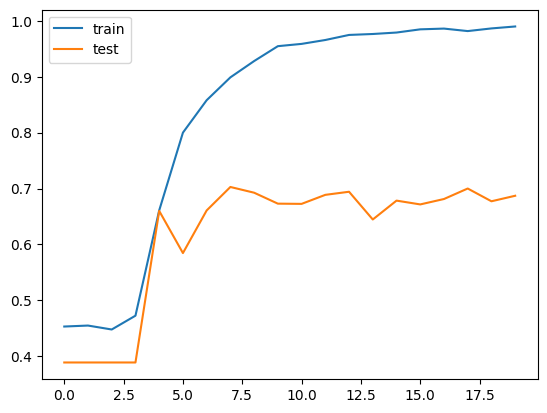

In [ ]:
ins = Instructor(args, logger)
ins.run()